### __FOREWORD__

This is an attempt to utilise machine learning models to predict house prices in King's county, Seattle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import folium
from branca.colormap import linear

In [2]:
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

### __THE DATA AND DATA DICTIONARY__

__Quick Note__: This data dictionary is sourced online and is likely not provided by the [dataset][harlfoxem-housesalesprediction] owner since there is no data dictionary associated to the dataset. Some minor errors found pertaining to the `id` column of the data dictionary. This is, however, unlikely to affect the accuracy of any ML models since the `id` column will eventually be dropped during the pre-processing stage of building ML models.

Feature Columns of the [dataset][harlfoxem-housesalesprediction]
    
* id - Unique ID for each home sold <ins>*(this is wrong and will be explained below)*</ins>
* date - Date of the home sale
* price - Price of each home sold
* bedrooms - Number of bedrooms
* bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
* sqft_living - Square footage of the apartments interior living space
* sqft_lot - Square footage of the land space
* floors - Number of floors
* waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
* view - An index from 0 to 4 of how good the view of the property was
* condition - An index from 1 to 5 on the condition of the apartment,
* grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
* sqft_above - The square footage of the interior housing space that is above ground level
* sqft_basement - The square footage of the interior housing space that is below ground level
* yr_built - The year the house was initially built
* yr_renovated - The year of the house’s last renovation
* zipcode - What zipcode area the house is in
* lat - Lattitude
* long - Longitude
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

[harlfoxem-housesalesprediction]: https://www.kaggle.com/harlfoxem/housesalesprediction

In [6]:
file_github = './dataset/kc_house_data.csv'
file_kaggle = '/kaggle/input/housesalesprediction/kc_house_data.csv'
try:
    df = pd.read_csv(file_github, parse_dates=['date'])
except:
    df = pd.read_csv(file_kaggle, parse_dates=['date'])

df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0           0     0          3      7        1180   
1      7242     2.0           0     0          3      7        2170   
2     10000     1.0           0     0          3      6         770   
3      5000     1.0           0     0          5      7        1050   
4      8080     1.0           0     0          3      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

### __UNCOVERING DUPLICATES AND NULLS, AND BROAD INFORMATION ABOUT THE DATASET__

In [7]:
shape = df.shape
duplicates = df.duplicated().sum()
nulls = df.isnull().sum().sum()
unique_id = df['id'].nunique()

print(f'Shape of the datafrae: rows: {shape[0]}, columns: {shape[1]}')
print(f'Number of duplicates in the dataframe: {duplicates}')
print(f'Number of nulls in the dataframe: {nulls}')
print(f'Unique participants in the dataframe: {unique_id}')

Shape of the datafrae: rows: 21597, columns: 21
Number of duplicates in the dataframe: 0
Number of nulls in the dataframe: 0
Unique participants in the dataframe: 21420


<ins>Some General Findings</ins>
- There are 21597 rows but only 21420 unique ids. In the data dictionary, I did not find the data dictionary helpful in clarifying what the `id` column meant. Does the transaction get a unique id, or each house gets a unique id? If each transaction gets a unique id, then this suggests data quality issues with the dataset. Further investigation needs to be perform on the id column to find duplicates.

In [8]:
# df[df['id'].duplicated(keep=False)]['id'].value_counts()
df_duplicated_id = df[df['id'].duplicated(keep=False)].copy()

In [9]:
df_duplicated_id.head(10)
# df_duplicated_id.iloc[0, :] == df_duplicated_id.iloc[1, :]
# df_duplicated_id['id'].value_counts()

id       date      price  bedrooms  bathrooms  sqft_living  \
93   6021501535 2014-07-25   430000.0         3       1.50         1580   
94   6021501535 2014-12-23   700000.0         3       1.50         1580   
313  4139480200 2014-06-18  1380000.0         4       3.25         4290   
314  4139480200 2014-12-09  1400000.0         4       3.25         4290   
324  7520000520 2014-09-05   232000.0         2       1.00         1240   
325  7520000520 2015-03-11   240500.0         2       1.00         1240   
345  3969300030 2014-07-23   165000.0         4       1.00         1000   
346  3969300030 2014-12-29   239900.0         4       1.00         1000   
371  2231500030 2014-10-01   315000.0         4       2.25         2180   
372  2231500030 2015-03-24   530000.0         4       2.25         2180   

     sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
93       5000     1.0           0     0          3      8        1290   
94       5000     1.0           0     0          3      8        1290   
313     12103     1.0           0     3          3     11        2690   
314     12103     1.0           0     3          3     11        2690   
324     12092     1.0           0     0          3      6         960   
325     12092     1.0           0     0          3      6         960   
345      7134     1.0           0     0          3      6        1000   
346      7134     1.0           0     0          3      6        1000   
371     10754     1.0           0     0          5      7        1100   
372     10754     1.0           0     0          5      7        1100   

     sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
93             290      1939             0    98117  47.6870 -122.386   
94             290      1939             0    98117  47.6870 -122.386   
313           1600      1997             0    98006  47.5503 -122.102   
314           1600      1997             0    98006  47.5503 -122.102   
324            280      1922          1984    98146  47.4957 -122.352   
325            280      1922          1984    98146  47.4957 -122.352   
345              0      1943             0    98178  47.4897 -122.240   
346              0      1943             0    98178  47.4897 -122.240   
371           1080      1954             0    98133  47.7711 -122.341   
372           1080      1954             0    98133  47.7711 -122.341   

     sqft_living15  sqft_lot15  
93            1570        4500  
94            1570        4500  
313           3860       11244  
314           3860       11244  
324           1820        7460  
325           1820        7460  
345           1020        7138  
346           1020        7138  
371           1810        6929  
372           1810        6929

- Taking just the first 2 rows as an example, all columns except the date and price were identical. i.e. the characteristics of the house is identical for the id 6021501535, except the date (which i assume is the transaction date) and price (which i assume is the transaction price). You can further verify this by uncommenting the second line of the above code chunk.
- This implies that the `id` column refers not to the transaction is, but the id of the house, and each record within the dataset is a unique transaction

### __INVESTIGATING GEOSPATIAL INFORMATION IN THE DATASET__

In [13]:
shp_incorp_github = './dataset/incorporated_area_king_country_shp/Incorporated_Areas_of_King_County___citydst_area.shp'
shp_incorp_kaggle = '/kaggle/input/incorporated-area-king-county/incorporated_area_king_country_shp/Incorporated_Areas_of_King_County___citydst_area.shp'

try:
    king_county = gpd.read_file(shp_incorp_github)
except:
    king_county = gpd.read_file(shp_incorp_kaggle)

king_county.head()
subset = king_county[king_county['NAME'].isin(
    ['Kent', 'Bellevue', 'Mercer Island', 'Seattle', 'Enumclaw', 'Carnation', 'Duvall', 'Snoqualmie', 'North Bend', 'Newcastle', 'Medina'])]

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_74883/3787548773.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for name, x, y in zip(subset['NAME'], subset['geometry'].centroid.x, subset['geometry'].centroid.y):


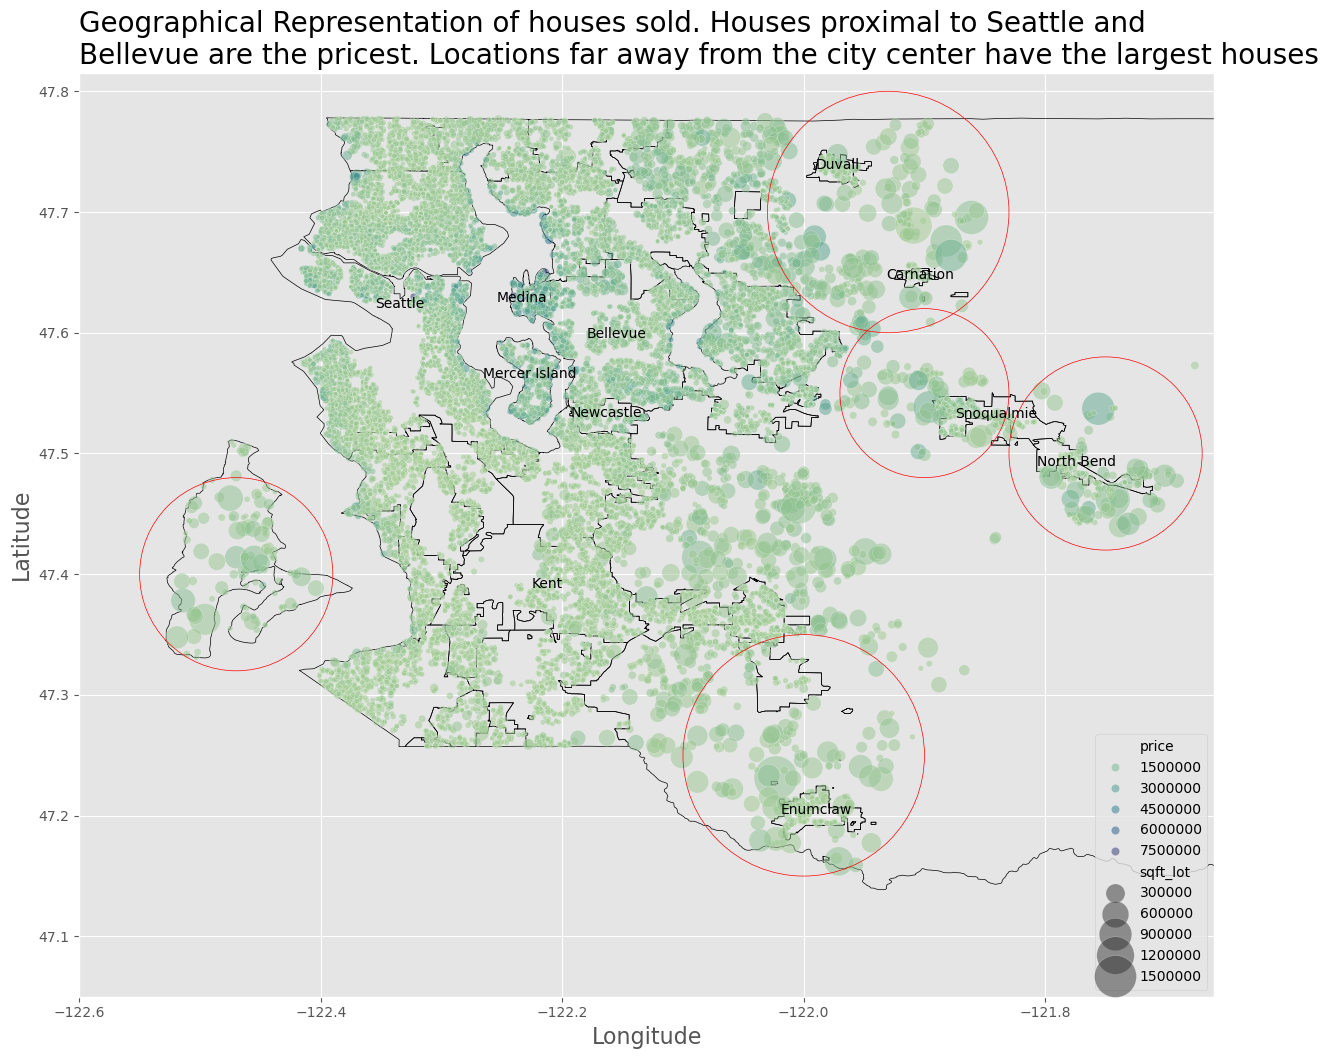

In [14]:
fig, ax = plt.subplots(figsize=(18,12))

color_map = sns.color_palette('crest', as_cmap=True)

# This is a plot of the boundaries incorporated areas in King County
king_county.plot(ax=ax, edgecolor='black', color='None')

# This is a scatterplot of all transactions that occurred
sns.scatterplot(data=df, ax=ax, x='long', y='lat', alpha=0.5,
                palette=color_map, hue='price', size='sqft_lot', sizes=(10, 1000))

# Annotating the names of districts
for name, x, y in zip(subset['NAME'], subset['geometry'].centroid.x, subset['geometry'].centroid.y):
    ax.annotate(text=name, xy=(x, y), xycoords = 'data', ha='center', size=10)

# Adding titles, legends to the visualisation
ax.legend(loc='lower right')
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_title('Geographical Representation of houses sold. Houses proximal to Seattle and \
             \nBellevue are the pricest. Locations far away from the city center have the largest houses', loc='left', fontsize=20)
ax.set_xlim(-122.6, -121.66)

# These circles highlight locations where houses are the largest
circle1 = plt.Circle(xy=(-122.0, 47.25), radius=0.1,
                     color='red', fill=False)
circle2 = plt.Circle(xy=(-121.75, 47.5), radius=0.08,
                     color='red', fill=False)
circle3 = plt.Circle(xy=(-122.47, 47.4), radius=0.08,
                     color='red', fill=False)
circle4 = plt.Circle(xy=(-121.93, 47.7), radius=0.1,
                     color='red', fill=False)
circle5 = plt.Circle(xy=(-121.90, 47.55), radius=0.07,
                     color='red', fill=False)

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.add_patch(circle5)
ax.set_aspect('equal')

Transactions with the highest prices occur at prime locations such as Mercer Island, Seattle, and Bellevue, and Medina. Houses in prime locations also tend to be relatively small. The largest houses can be found in Vashon Island, and the outskirts of King's County like Enumclaw, North Bend, Snoqualmie, Carnation, and Duvali.

In [15]:
# We take the mean of house transactions in each zipcode. This will be information used to color the choropleth map
mean_price_for_zipcode = df.groupby('zipcode')[['price']].agg('mean')
mean_price_for_zipcode = mean_price_for_zipcode.reset_index()

# We change the datatype of zipcode for 2 reasons: First, a zipcode has no quantitative meaning, and conversion is needed to merge with the zipcode shape file
mean_price_for_zipcode['zipcode'] = mean_price_for_zipcode['zipcode'].astype(
    'str')
mean_price_for_zipcode.rename(columns={'zipcode': 'ZIPCODE'}, inplace=True)

In [16]:
# Next, we are using another shape file to plot a choropleth map of house prizes
shp_zipcode_github = './dataset/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp'
shp_zipcode_kaggle = '/kaggle/input/king-county-shapefiles/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp'

try:
    king_county_zipcode = gpd.read_file(shp_zipcode_github)
except:
    king_county_zipcode = gpd.read_file(shp_zipcode_kaggle)
    
king_county_zipcode.head()

# Instead of plotting all polygons, only zipcodes contained in the house sales dataset will be plotted
king_county_zipcode_partial = king_county_zipcode[king_county_zipcode['ZIPCODE'].isin(
    mean_price_for_zipcode['ZIPCODE'].unique())]

In [17]:
# This is used for the tooltip
for_tooltip = king_county_zipcode_partial.merge(
    mean_price_for_zipcode, on='ZIPCODE')

In [18]:
m_1 = folium.Map(location=[47.5480, -121.9836],
                 default_zoom_start=.5, tiles='cartodbpositron')

colormap = linear.Greens_03.scale(100000, 2000000)

cp = folium.Choropleth(
    geo_data=for_tooltip,
    data=mean_price_for_zipcode,
    columns=['ZIPCODE', 'price'],
    key_on='feature.properties.ZIPCODE',    # This refers to the geo_data
    fill_color='Greens',
    fill_opacity=0.6,
    legend_name='Mean Sale Price'
).add_to(m_1)

folium.GeoJsonTooltip(
    fields=["PREFERRED_", "ZIPCODE", "price"],
    aliases=["County:", "Zipcode:", "Mean Transaction Price:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
).add_to(cp.geojson)

# for index, row in df.iterrows():
#     folium.Circle(
#         location=[row['lat'], row['long']],
#         radius=0.1,
#         color=colormap(row['price']),
#         alpha=0.4
#     ).add_to(m_1)


# for index, row in king_county_zipcode_partial.iterrows():
#     folium.Marker(
#         location=[row.geometry.centroid.y, row.geometry.centroid.x],
#         tooltip=row['PREFERRED_']
#         ).add_to(m_1)

m_1

### __EXPLORATORY DATA ANALYSIS__

In [19]:
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0           0     0          3      7        1180   
1      7242     2.0           0     0          3      7        2170   
2     10000     1.0           0     0          3      6         770   
3      5000     1.0           0     0          5      7        1050   
4      8080     1.0           0     0          3      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [20]:
continuous_var = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
categorical_var = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', ]

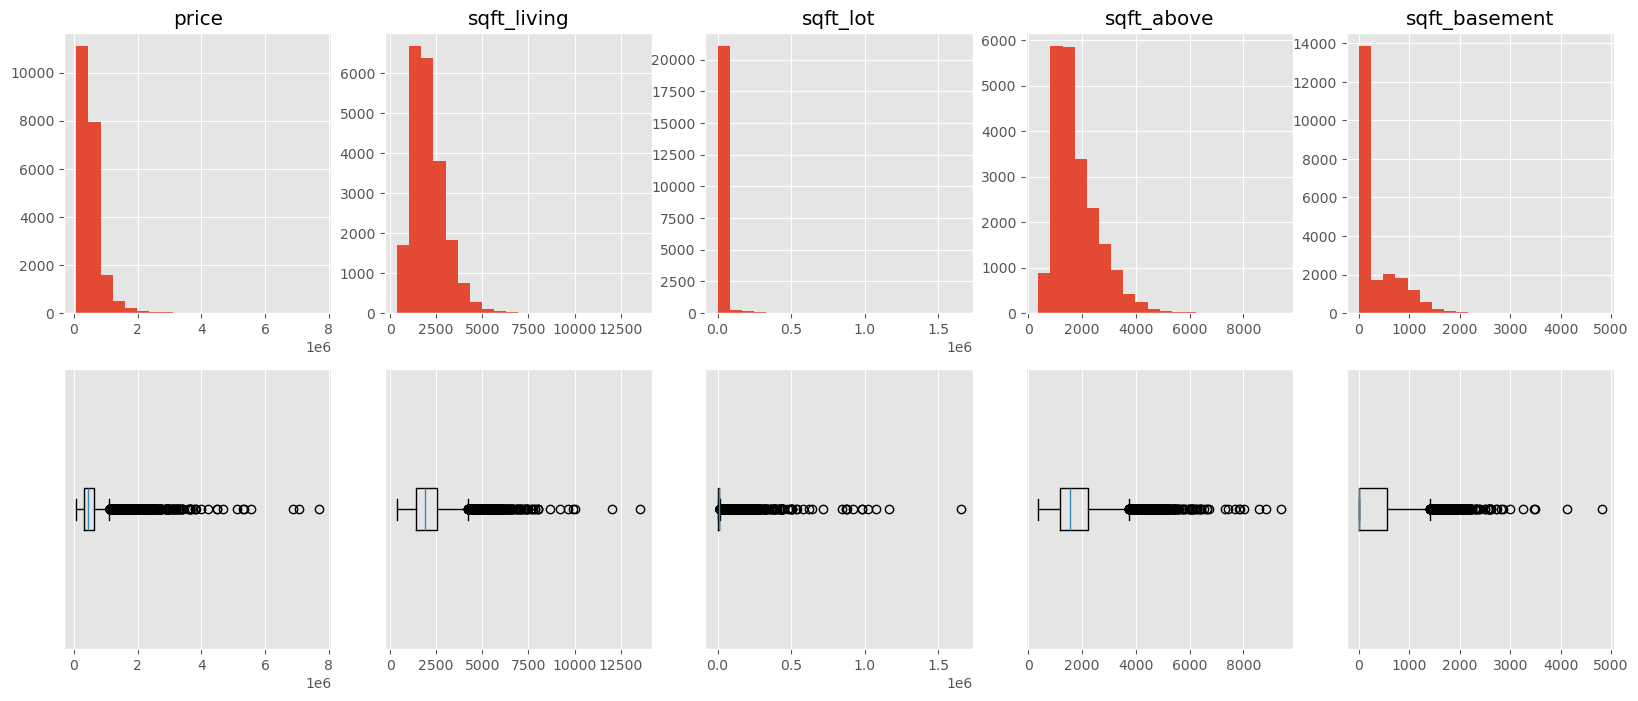

In [21]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(20, 8)

for index, column in enumerate(continuous_var):
    ax.flatten()[index].hist(df[column], bins=20)
    ax.flatten()[index].set_ylabel('')
    ax.flatten()[index].set_title(column)

for index, column in enumerate(continuous_var):
    ax.flatten()[index + 5].boxplot(df[column], vert=False)
    ax.flatten()[index + 5].set_yticks([])

There is an interesting outlier in the `sqft_loft` column. We should investigate that outlier further.
- The outlier begs the question: how can there be only 1300 square feet of living space in a 1.65 million square feet lot that costs a 6-figure sum?!
- The second largest square footage property is even more ludicrous. 1.16 million square feet for only less than 200 thousand dollars?!
- For [reference][million-square-feet], 1 million square feet is 40 times larger than the white house! Surely there must be some form of error in the data

[million-square-feet]: https://www.quora.com/What-would-1-million-square-feet-look-like

In [22]:
df.sort_values('sqft_lot', ascending=False).head(10)

id       date      price  bedrooms  bathrooms  sqft_living  \
1717   1020069017 2015-03-27   700000.0         4       1.00         1300   
17305  3326079016 2015-05-04   190000.0         2       1.00          710   
7640   2623069031 2014-05-21   542500.0         5       3.25         3010   
7762   2323089009 2015-01-19   855000.0         4       3.50         4030   
3945    722069232 2014-09-05   998000.0         4       3.25         3770   
4437   3626079040 2014-07-30   790000.0         2       3.00         2560   
6685   2624089007 2015-03-20  2000000.0         2       2.50         3900   
7070   2724079090 2015-01-05  1650000.0         4       3.25         3920   
9705    225079036 2015-01-07   937500.0         4       4.00         5545   
20436  1125079111 2015-04-15  1600000.0         4       5.50         6530   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
1717    1651359     1.0           0     3          4      6        1300   
17305   1164794     1.0           0     0          2      5         710   
7640    1074218     1.5           0     0          5      8        2010   
7762    1024068     2.0           0     0          3     10        4030   
3945     982998     2.0           0     0          3     10        3770   
4437     982278     1.0           0     0          3      8        2560   
6685     920423     2.0           0     0          3     12        3900   
7070     881654     3.0           0     3          3     11        3920   
9705     871200     2.0           0     0          3     11        3605   
20436    871200     2.0           0     2          3     11        6530   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
1717               0      1920             0    98022  47.2313 -122.023   
17305              0      1915             0    98014  47.6888 -121.909   
7640            1000      1931             0    98027  47.4564 -122.004   
7762               0      2006             0    98045  47.4619 -121.744   
3945               0      1992             0    98058  47.4140 -122.087   
4437               0      2004             0    98014  47.6955 -121.861   
6685               0      2009             0    98065  47.5371 -121.756   
7070               0      2002             0    98024  47.5385 -121.896   
9705            1940      2003             0    98014  47.6760 -121.882   
20436              0      2008             0    98014  47.6640 -121.878   

       sqft_living15  sqft_lot15  
1717            2560      425581  
17305           1680       16730  
7640            2450       68825  
7762            1830       11700  
3945            2290       37141  
4437            1620       40946  
6685            2720      411962  
7070            2970      112384  
9705            3420      871200  
20436           1280      858132

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_74883/84632677.py:10: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  local_ax.annotate(f'{skew:.2f}', xy=(0.9, 0.04), textcoords='axes fraction')


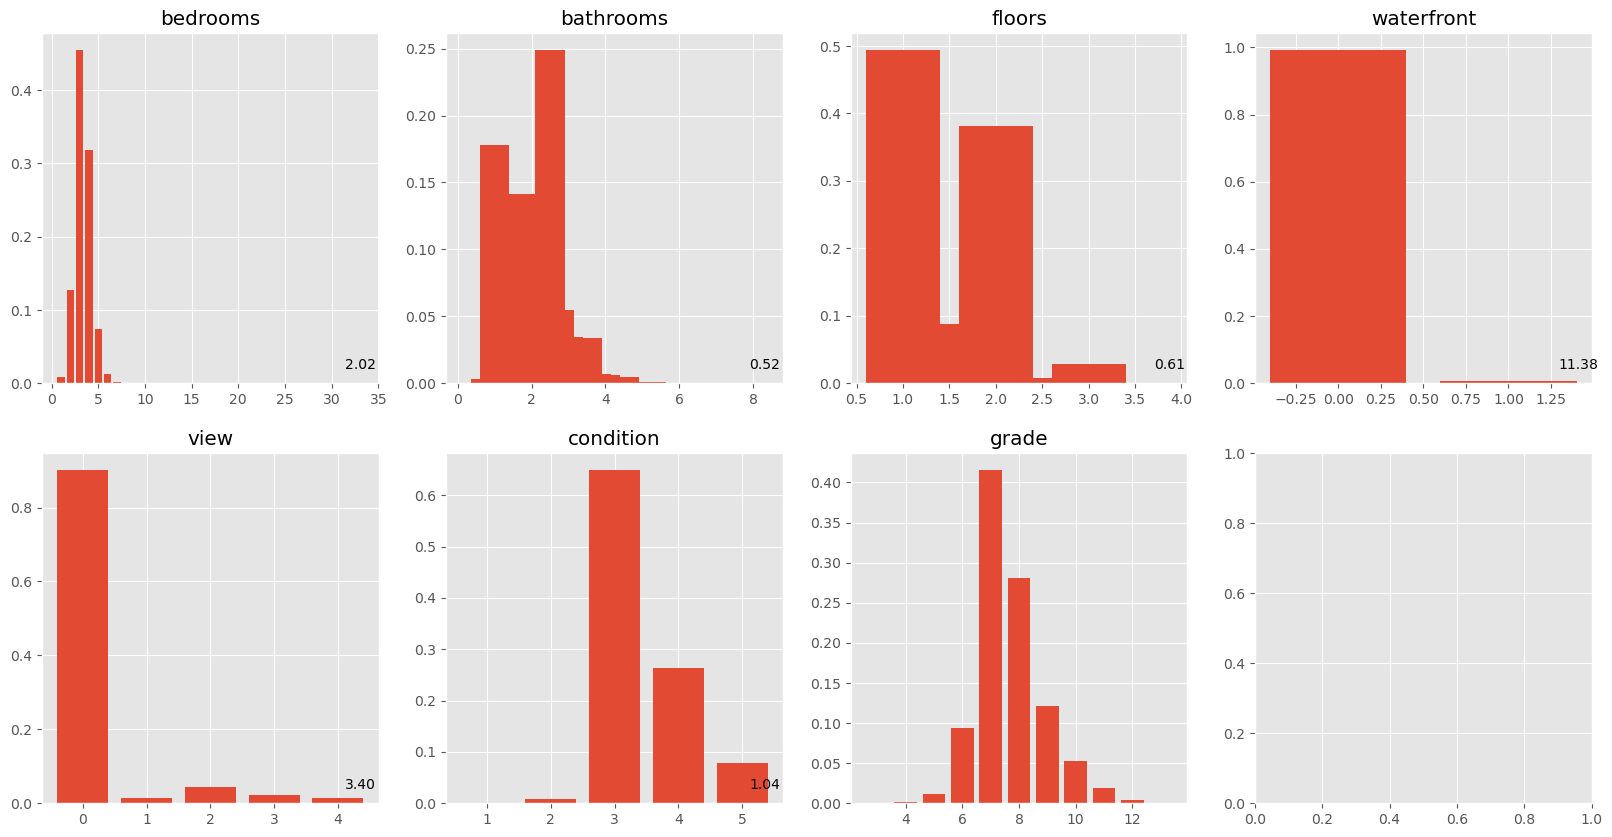

In [23]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(20, 10)

for index, column in enumerate(categorical_var):
    local_ax = ax.flatten()[index]
    skew = df[column].skew()
    data = df[column].value_counts() / df.shape[0]
    local_ax.bar(data.index, data.values)
    local_ax.set_title(column)
    local_ax.annotate(f'{skew:.2f}', xy=(0.9, 0.04), textcoords='axes fraction')

Creating a pairplot to examine continuous features of the dataset

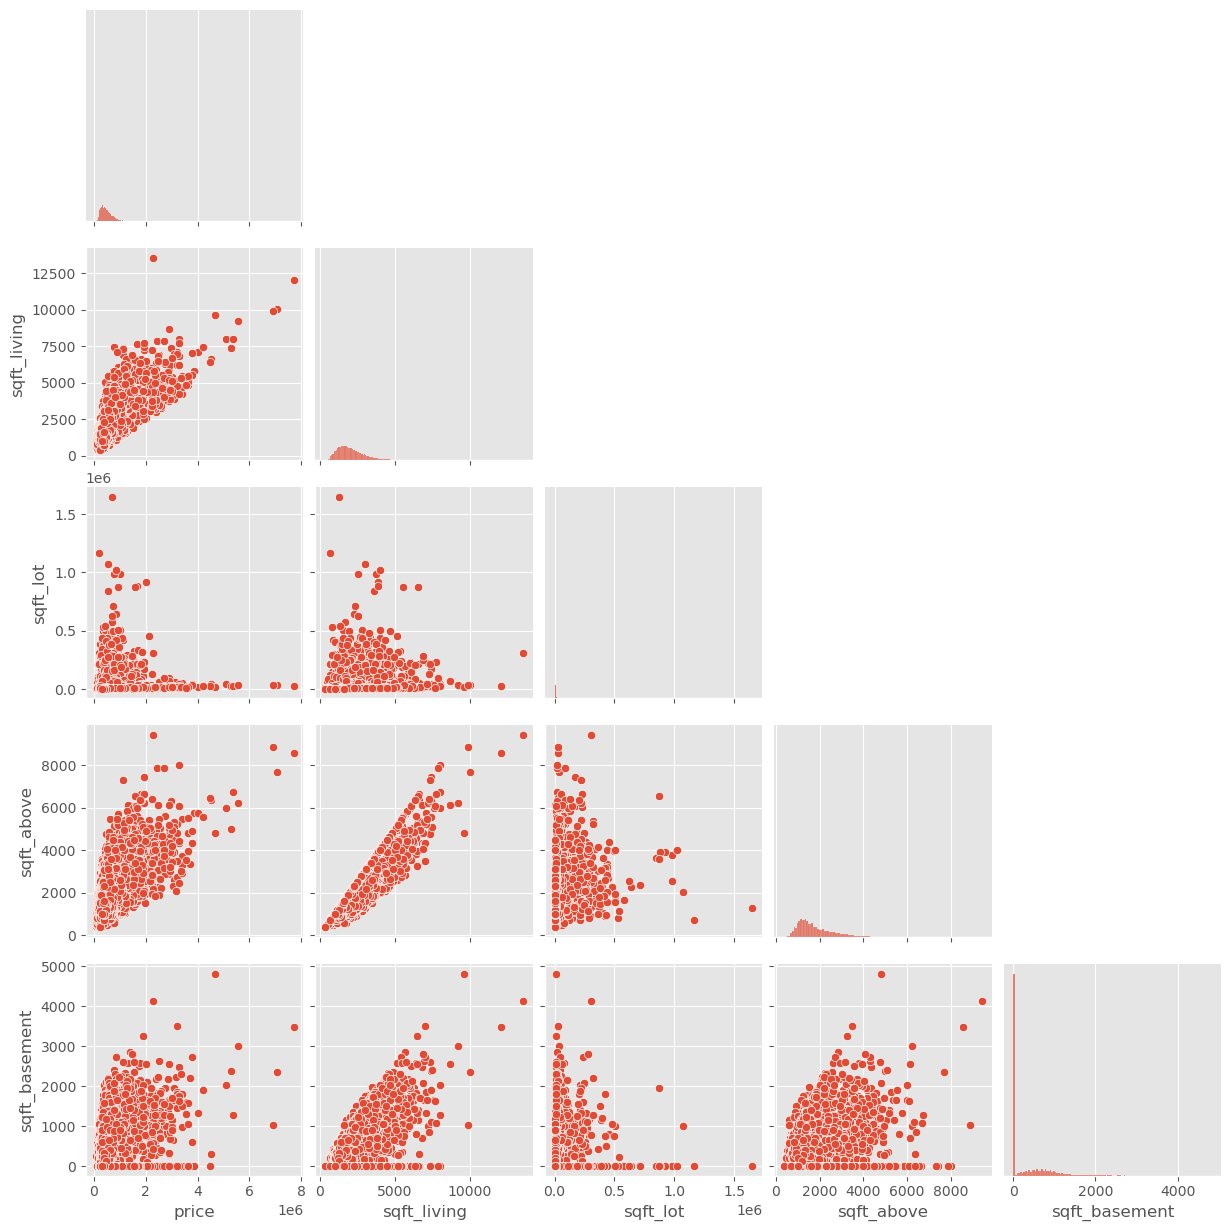

In [24]:
g = sns.pairplot(data=df.loc[:, continuous_var], corner=True)

Creating a pairplot to examine categorical features of the dataset

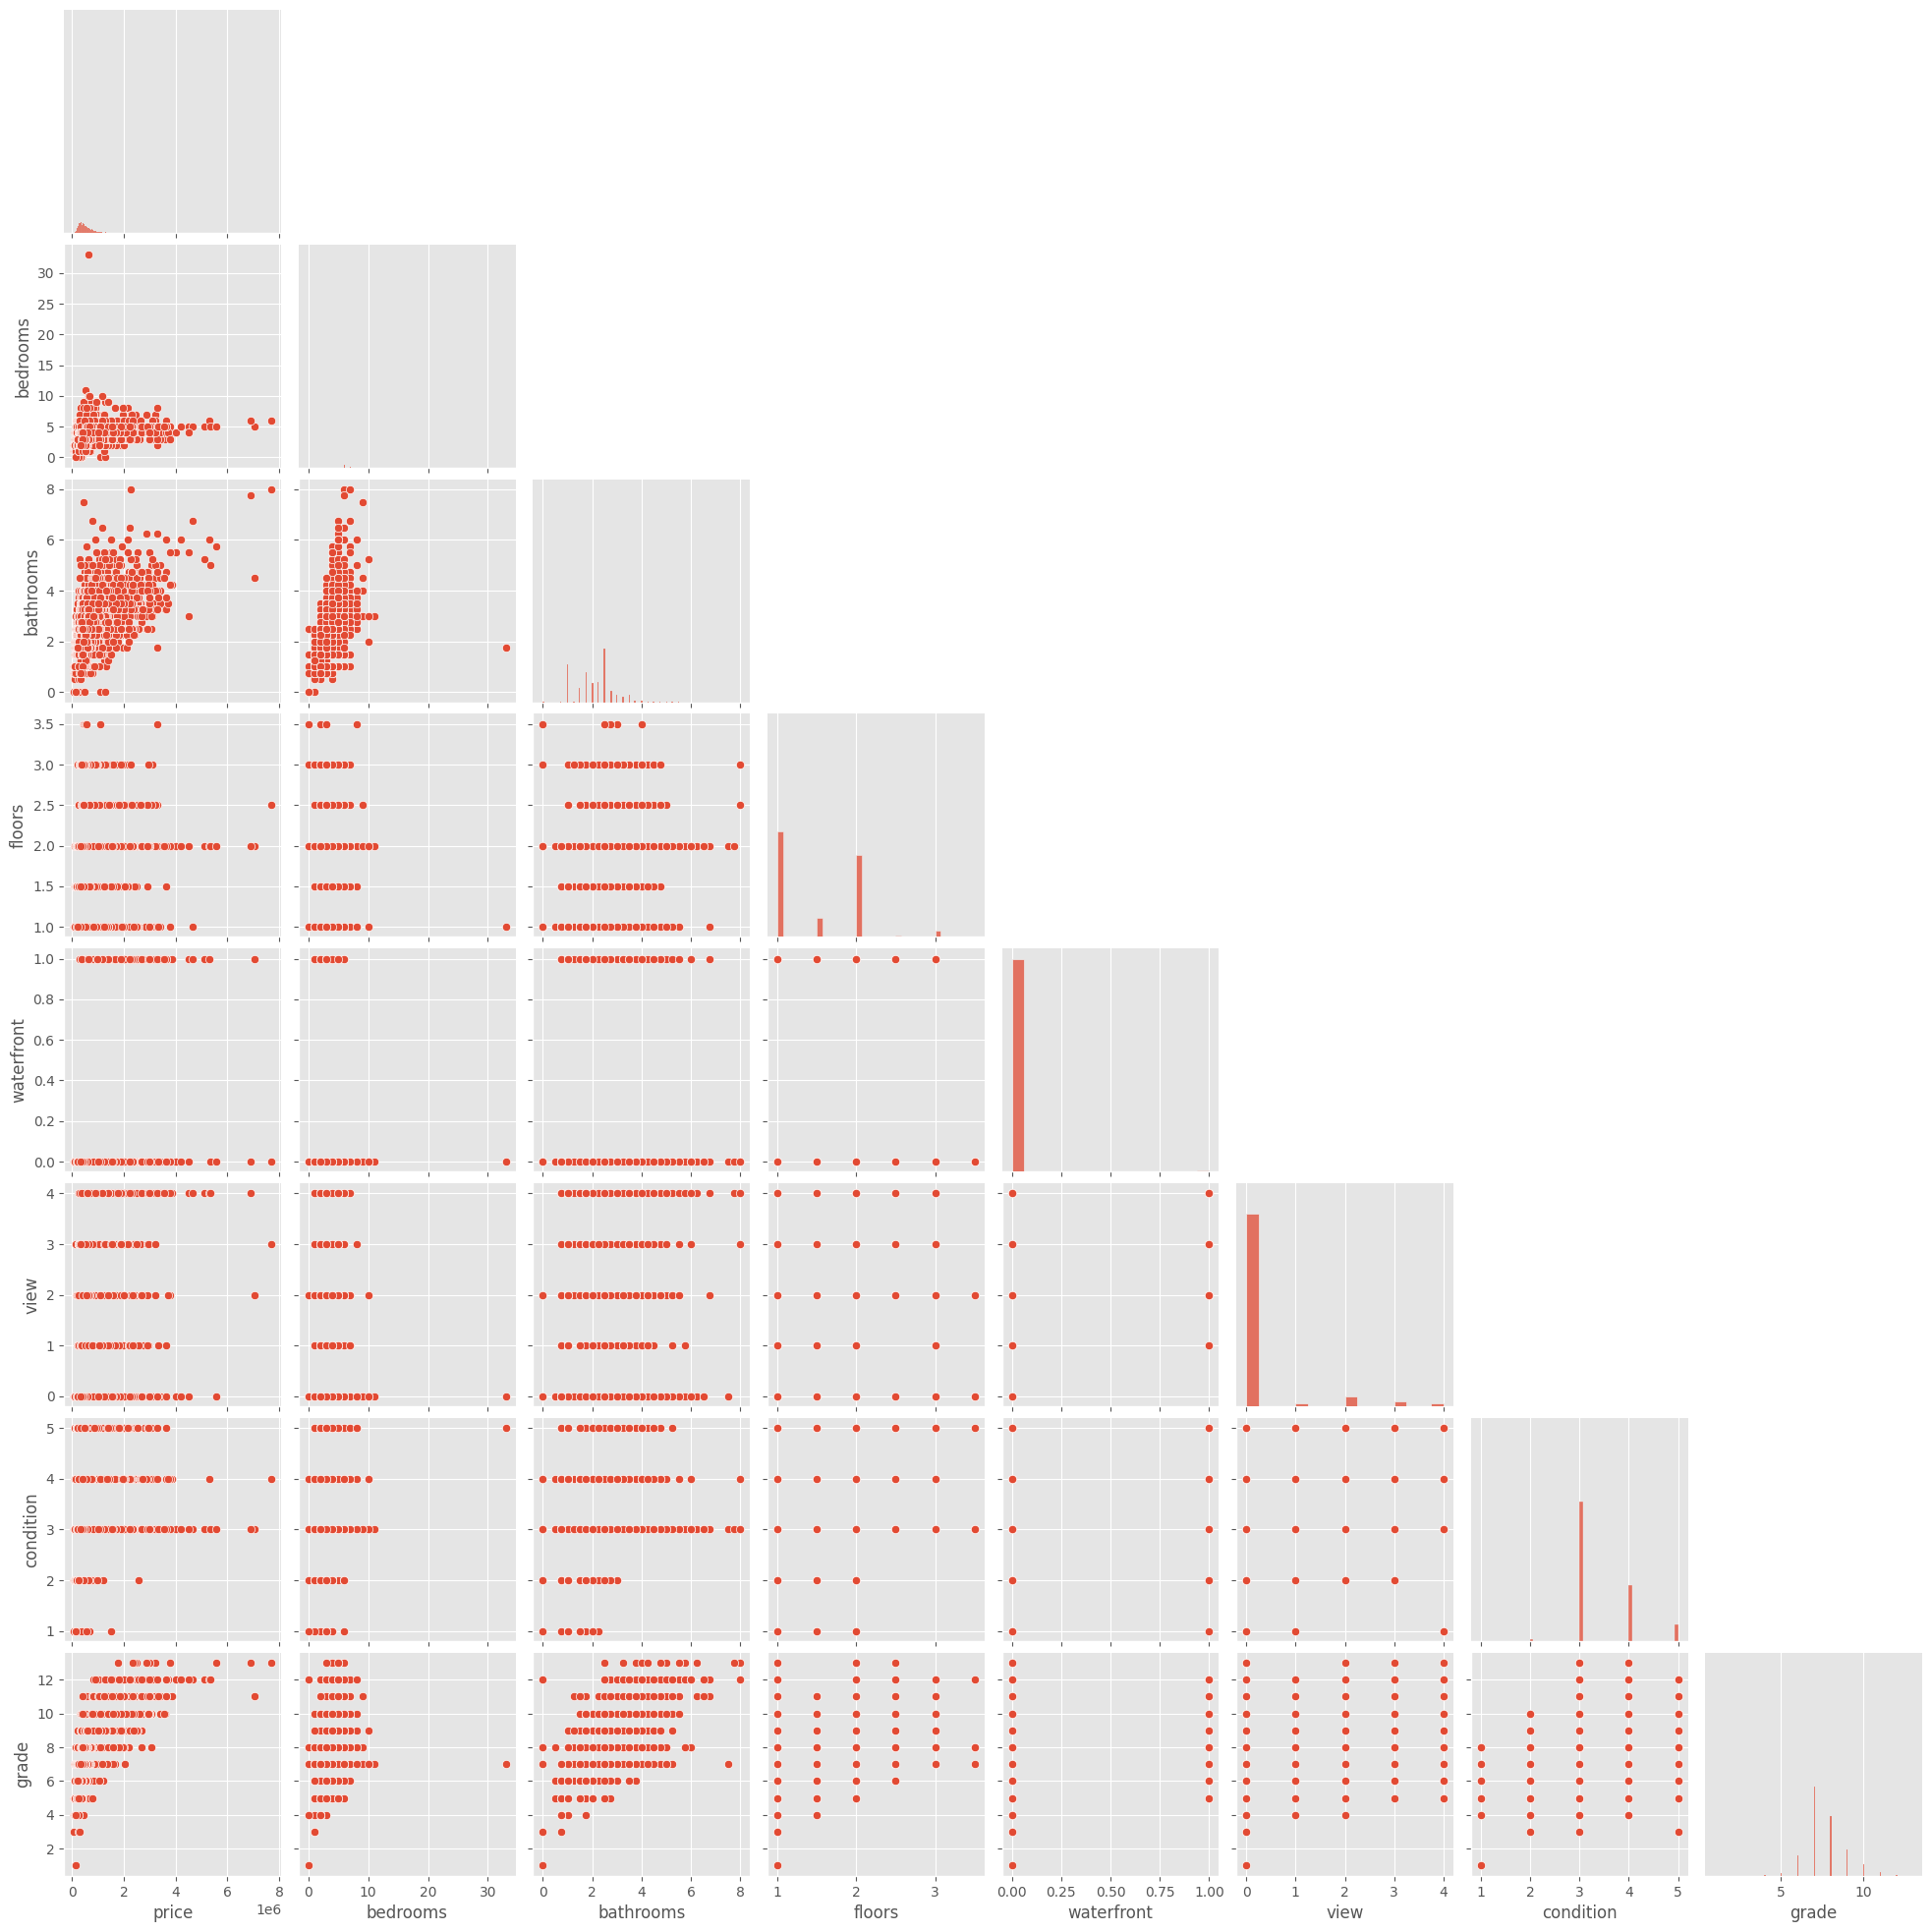

In [20]:
categorical_var_pairplot = ['price', 'bedrooms', 'bathrooms',
                   'floors', 'waterfront', 'view', 'condition', 'grade', ]
g = sns.pairplot(data=df.loc[:, categorical_var_pairplot], corner=True)

<Axes: >

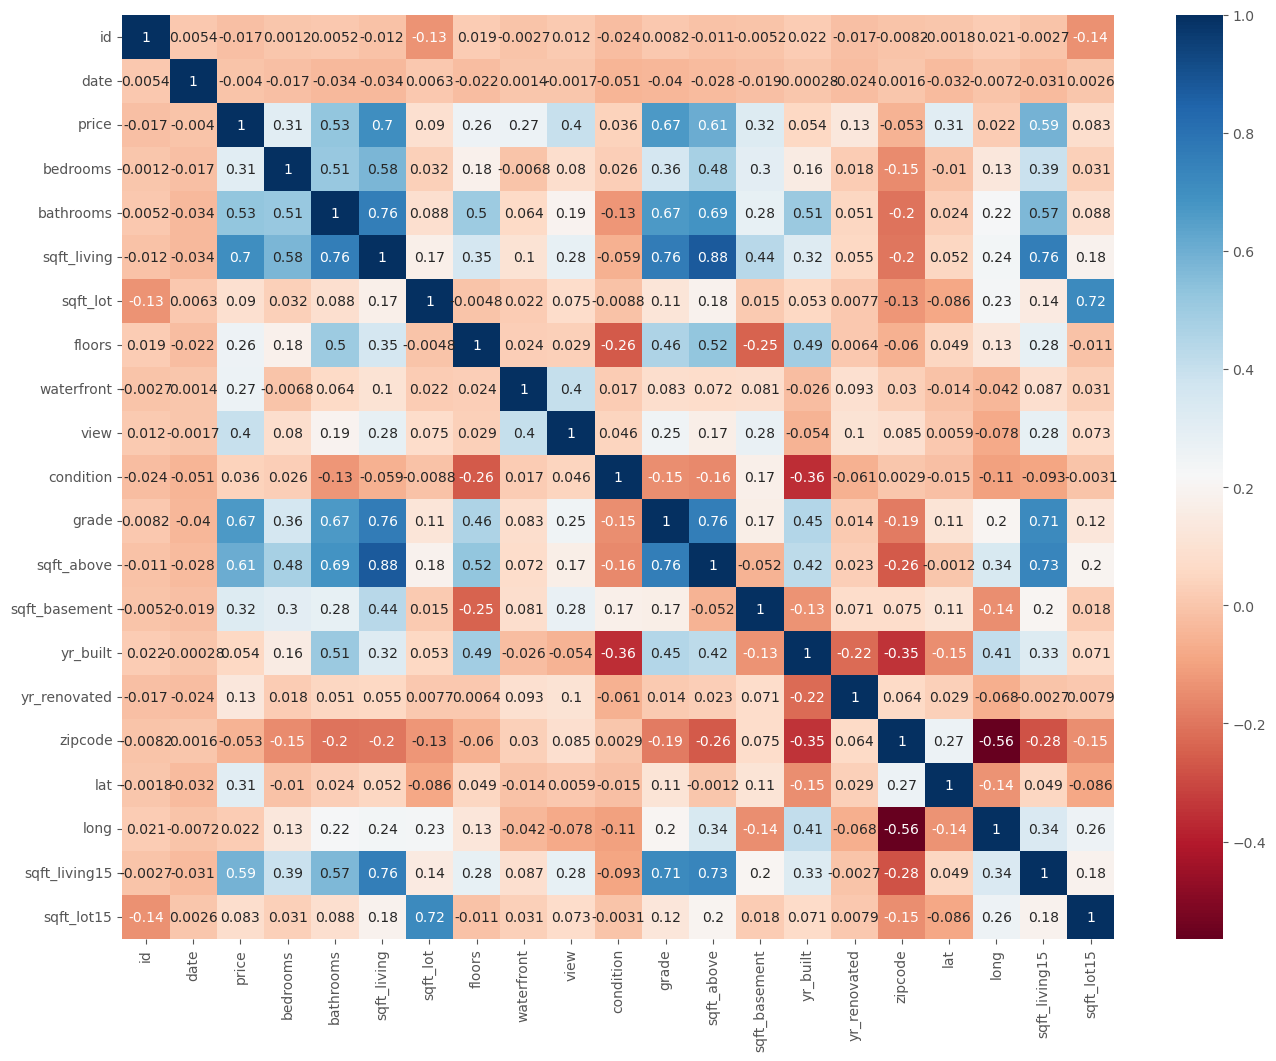

In [32]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), cmap='RdBu', annot=True)

### __FEATURE ENGINEERING AND PREPROCESSING__

Summary of Findings
- `id` will be dropped since it has no utility except for identifying each unique property
- `date` will be dropped since no seasonality effects and a lack of longitudinal data are limitations of the column
- `lat` and `long` will be dropped and `zipcode` will be retained. `zipcode` contains sufficient spatial information to inform how location affects the price of the property.
- `yr_built` and `yr_renovated` will be dropped, and a newly feature called `refurbished_yrs_ago` is created to provide information about the upkeep of the house. The greater the value, the less likely the house is well-kept
- `sqft_living15` and `sqft_lot15` will be dropped. Information about the nearest 15 neighbours can be addequately captured by zipcode

#### We have decided to drop the `date` column from the dataset due to insufficient longitudinal data and seasonal patterns

Investigating the significance of including the date in the dataset

In [33]:
df['date'].max() - df['date'].min()

Timedelta('390 days 00:00:00')

There is slightly more than 1 year's worth of data in the dataset

In [34]:
# Calculate the year that the house was last refurbished. If the yr_renovated is 0, we take the last_refurnished year to be the year that the house was built
def last_refurbished(x):
    if x['yr_renovated'] == 0:
        return x['yr_built']
    else:
        return x['yr_renovated']
    
# Since the dataset records transaction dates from 2014 - 2015, let us assume that this model is built in 2016, else the data would be obselete in 2023.
df['refurbished_yrs_ago'] = 2016 - df.apply(last_refurbished, axis=1)

# df[['yr_built', 'yr_renovated', 'refurbished_yrs_ago']]

Investigating seasonality effects in the transaction price

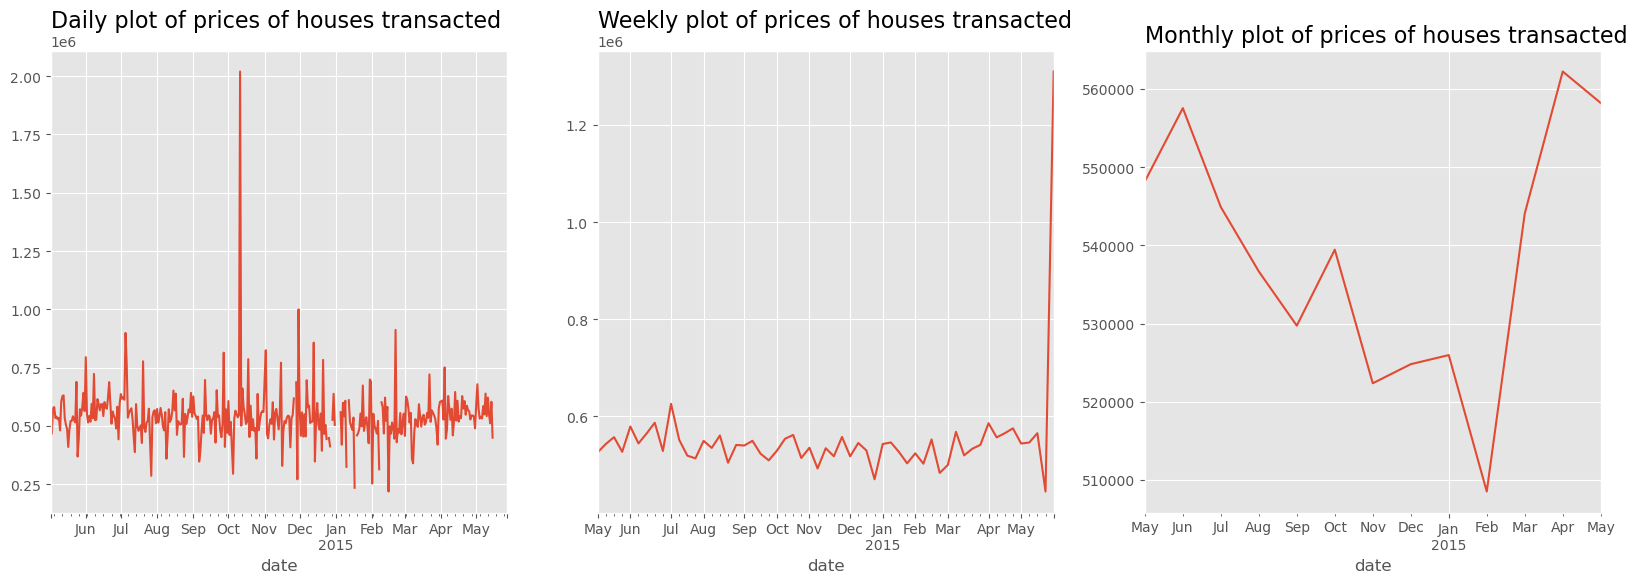

In [35]:
# Investigating whether there are seasonality effects to transaction prices
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for index, value in enumerate(['D', 'W', 'M']):
    df.groupby(pd.Grouper(key='date', freq=value)).agg('mean')['price'].plot(ax=ax.flatten()[index])
for index, value in enumerate(['Daily', 'Weekly', 'Monthly']):
    ax.flatten()[index].set_title(f'{value} plot of prices of houses transacted', loc='left', fontsize=16)

In [38]:
df['price'].corr(df['refurbished_yrs_ago'])

-0.10570291260134203

<Axes: xlabel='refurbished_yrs_ago', ylabel='price'>

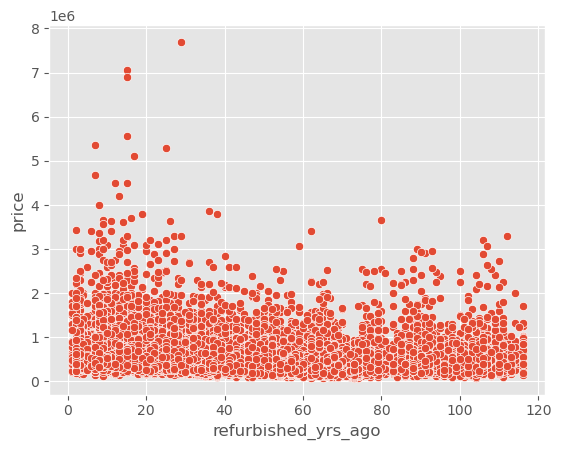

In [39]:
sns.scatterplot(data=df, x='refurbished_yrs_ago', y='price')

Summary of findings:
- The date will be dropped from the dataset. 
- We have created a new feature called `refurbished_yrs_ago` that describes how long since the property was last refurbished. A correlation coefficient of -0.1 was found between price and this variable, and the intuition is accurate since we expect that newly refurbished properties will fetch a higher price.

#### Converting `zipcode` to a string. This is because there is no quantitative significance to the value of zipcodes. I.e. a higher zipcode value does not imply that it is greater or lesser than a lower zipcode value

In [40]:
df['zipcode'] = df['zipcode'].astype('str')

In [41]:
df['zipcode'].to_numpy().reshape(-1, 1).shape

(21597, 1)

In [42]:
df = df.drop(['id', 'date', 'yr_built', 'yr_renovated', 'lat',
             'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21597 non-null  float64
 1   bedrooms             21597 non-null  int64  
 2   bathrooms            21597 non-null  float64
 3   sqft_living          21597 non-null  int64  
 4   sqft_lot             21597 non-null  int64  
 5   floors               21597 non-null  float64
 6   waterfront           21597 non-null  int64  
 7   view                 21597 non-null  int64  
 8   condition            21597 non-null  int64  
 9   grade                21597 non-null  int64  
 10  sqft_above           21597 non-null  int64  
 11  sqft_basement        21597 non-null  int64  
 12  zipcode              21597 non-null  object 
 13  refurbished_yrs_ago  21597 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 2.3+ MB


### CREATING THE MODEL

In [44]:
# we need scikit-learn 1.3 for preprocessing. Specifically, we are utilising targetencoder to encode the zipcode column in our dataset
!pip install --upgrade scikit-learn

In [45]:
import sklearn
sklearn.__version__

'1.3.2'

In [46]:
X = df.drop(['price'], axis=1)
y = df['price']

In [50]:
from sklearn.preprocessing import StandardScaler, TargetEncoder, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

numeric_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                   'refurbished_yrs_ago', 'bedrooms', 'bathrooms', 'view', 'condition', 'grade', 'floors']
numeric_transformer = Pipeline(steps=[
    ('z_normalisation', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson'))
])

categorical_columns = ['waterfront']
categorical_transformer = Pipeline(steps=[
    ('one_hot_encoding', OneHotEncoder(drop='first'))
])

label_encode_columns = ['zipcode']
label_encode_transformer = Pipeline(steps=[
    ('label_encode', TargetEncoder(smooth='auto', target_type='continuous'))
])


preprocessing = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_columns),
    ('categorical', categorical_transformer, categorical_columns),
    ('label_encode', label_encode_transformer, label_encode_columns)
    ],
    remainder='drop'
)

In [57]:
linear_reg = LinearRegression()

pipe_lr = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('linear', linear_reg)
])

pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_test)

price_range = y_train.max() - y_train.min()
norm_rmse_lr = (np.sqrt((y_test - pred)**2)).mean() / price_range
r2_lr = r2_score(y_test, pred)

print(f'normalised RMSE: {norm_rmse_lr:.5f}')
print(f'r2 Score: {r2_lr:.2f}')

normalised RMSE: 0.01509
r2 Score: 0.73


In [56]:
rf = RandomForestRegressor(n_estimators=300, random_state=0)

pipe_rf = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('random_forest', rf)
])

pipe_rf.fit(X_train, y_train)
pred = pipe_rf.predict(X_test)

price_range = y_train.max() - y_train.min()
norm_rmse_rf = (np.sqrt((y_test - pred)**2)).mean() / price_range
r2_rf = r2_score(y_test, pred)

print(f'normalised RMSE: {norm_rmse_rf:.5f}')
print(f'r2 Score: {r2_rf:.2f}')

normalised RMSE: 0.00973
r2 Score: 0.87


In [58]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)

pipe_xgb = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('xg_boost', xgb)
])

pipe_xgb.fit(X_train, y_train)
pred = pipe_xgb.predict(X_test)

price_range = y_train.max() - y_train.min()
norm_rmse_xgb = (np.sqrt((y_test - pred)**2)).mean() / price_range
r2_xgb = r2_score(y_test, pred)

print(f'normalised RMSE: {norm_rmse_xgb:.5f}')
print(f'r2 Score: {r2_xgb:.2f}')

normalised RMSE: 0.00959
r2 Score: 0.88


Linear Regression, Random Forests, and XGBoost models were created to predict House prices. The XGBoost model performed the best, having a normalised RMSE value of 0.0093. This means that the error is 0.93% of the range of the values within the dataset

Further plans to implement Cross validation to fine-tune hyperparameters of the model.